In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import datetime

import pyvips as pv
from sklearn.model_selection import StratifiedKFold

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [38]:
train_meta = pd.read_csv(f'{CFG.DATA_PATH}/train_metadata.csv')
train_labels = pd.read_csv(f'{CFG.DATA_PATH}/train_labels.csv')
train = train_meta.merge(train_labels, on='filename')

In [39]:
train['relapse'].sum()

213

In [40]:
def split_df(df, args):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df["fold"] = -1
    fold_idx = len(df.columns) - 1

    y = df[args['labels']]
    for i, (_, dev_index) in enumerate(kf.split(range(len(df)), y.values)):
        df.iloc[dev_index, fold_idx] = i

    return (
        df[df.fold != args['fold']].reset_index(drop=True),
        df[df.fold == args['fold']].reset_index(drop=True),
    )

In [41]:
args = {'labels': 'relapse', 'fold': 1}
train, valid = split_df(train, args)

In [44]:
def read_img(path, page=4):
    slide = pv.Image.new_from_file(str(path), page=page)
    region = pv.Region.new(slide).fetch(0, 0, slide.width, slide.height)

    return np.ndarray(
        buffer=region, dtype=np.uint8, shape=(slide.height, slide.width, 3)
    )

def get_tiles(img, tile_size=256, n_tiles=36, mode=0):
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

    img = np.pad(
        img,
        [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=255,
    )
    img = img.reshape(
        img.shape[0] // tile_size, tile_size, img.shape[1] // tile_size, tile_size, 3
    )
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)

    n_tiles_with_info = (
        img.reshape(img.shape[0], -1).sum(1) < tile_size ** 2 * 3 * 255
    ).sum()
    if len(img) < n_tiles:
        img = np.pad(
            img, [[0, n_tiles - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255
        )

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:n_tiles]
    img = img[idxs]

    return img, n_tiles_with_info >= n_tiles

def get_filenames(df):
    df['filename'] = df['filename'].apply(lambda x: f'{CFG.DATA_PATH}/originals/{x}')
    return df

def concat_tiles(tiles, n_tiles, image_size, rand=False, transform=None):
    if rand:
        idxes = np.random.choice(list(range(n_tiles)), n_tiles, replace=False)
    else:
        idxes = list(range(n_tiles))

    n_row_tiles = int(np.sqrt(n_tiles))
    img = np.zeros(
        (image_size * n_row_tiles, image_size * n_row_tiles, 3), dtype="uint8"
    )
    for h in range(n_row_tiles):
        for w in range(n_row_tiles):
            i = h * n_row_tiles + w

            if len(tiles) > idxes[i]:
                this_img = tiles[idxes[i]]
            else:
                this_img = np.ones((image_size, image_size, 3), dtype="uint8") * 255

            if transform is not None:
                this_img = transform(this_img)

            h1 = h * image_size
            w1 = w * image_size
            img[h1 : h1 + image_size, w1 : w1 + image_size] = this_img

    if transform is not None:
        img = transform(img)

    return img

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

In [56]:
# train = get_filenames(train)
#row = train.iloc[0]
img = read_img(train.loc[2, 'filename'])
img, _ = get_tiles(
    img,
    # tile_size=self.config.train.tile_size,
    # n_tiles=self.config.train.n_tiles,
    mode=0,
)
img = concat_tiles(
    img,
    n_tiles=36,
    image_size=256,
    # rand=self.is_train,
    # transform=self.transform,
)

In [57]:
img.shape

(1536, 1536, 3)

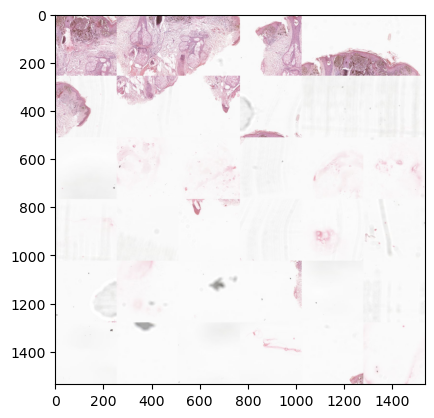

In [58]:
plt.imshow(img)

In [80]:
import torch

0.2221197776777555 0.1712991778015937


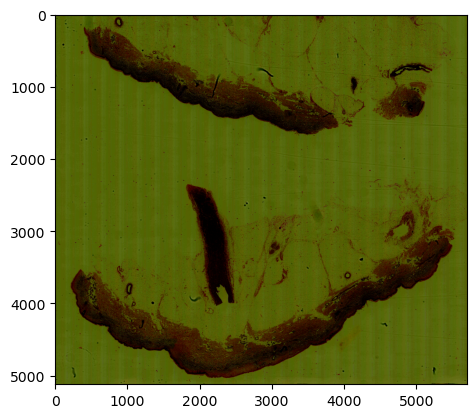

In [79]:
img = pv.Image.new_from_file(train.loc[5, 'filename'], page=4)
img = np.asarray(img) /255
img = (img - CFG.MUMEAN) / CFG.STDMEAN
img = np.clip(img, -1., 1.)
img = (img + 1) / 2

print(np.mean(img), np.std(img))
plt.imshow(img)